# Multigraph Representation Learning

Say you're a brain researcher, and you have a bunch of scans of people's brains - some are multiple scans of the same person, and some are scans of different people. You have an algorithm that lets you create networks from these brains, so you turn all your brain scans into networks. You want to know if two random scans from the same people are more similar than two random scans from different people. What do you do? It seems like they should be, but how can you actually test this? How do you even deal with situations in which you have a lot of networks whose nodes all represent the same objects, but which might look quite different?

Well, you could embed all of these networks separately with Adjacency Spectral Embedding or Laplacian Spectral Embedding, and presumably you'd learn something about their community structure that way. However, what you'd really like to do is combine them all into a single representation to learn from every network at once. This would serve the dual purpose of having less stuff to deal with, as well as having some way to directly compare embeddings which live in the same space. Figuring out the best way to represent groups of networks is a topic under active research, and the set of techniques and tools that have developed as a result are together called multigraph representation learning (here, "graph" just means "network").

In this section, we'll explore the strengths and weaknesses of different types of multigraph representation learning. Multiple Adjacency Spectral Embedding (MASE) is a technique which embeds a bunch of networks separately (with normal Adjacency Spectral Embedding), and then re-embeds all the separate results into a single space. MASE is nice because you don't actually need each network to be generated from the same distribution - you only need the nodes of the different networks to be aligned and for them to belong to the same communities. Omnibus embedding combines the adjacency matrix of all of the matrices into a single super-matrix, and then embeds that super-matrix.

## Multiple Adjacency Spectral Embedding

### A Collection of Networks

Suppose we have a set of networks generated from Stochastic Block Models with two communities in each network. The networks have aligned nodes -- meaning that the $i_{th}$ row of all of their adjacency matrices represent the same nodes. The nodes also all belong to the same communities. However, edge probabilities might change depending on the network - in the first network, you might have nodes in the same community having a high chance of connecting to each other, whereas in the second network, nodes are much more likely to be connected to other nodes in different communities. Your goal is to find a common space in which to represent all of these networks, that captures the common community structure in all of these.

Below is Python code which generates four networks with Stochastic Block Models. The labels are the same across the networks (which means that nodes have a consistent community no matter which network you're looking at), but the block probability matrices are quite different.

In [1]:
import numpy as np
from graspologic.simulations import sbm

n = 100
def make_sbm(*probs, n=100, return_labels=False):
    p1, p2, p3, p4 = probs
    P = np.array([[p1, p2], [p3, p4]])
    return sbm([n, n], P, return_labels=return_labels)

p1, p2, p3 = .12, .06, .03
A1, labels = make_sbm(p1, p3, p3, p1, 
                      return_labels=True)
A2 = make_sbm(p1, p3, p3, p2)
A3 = make_sbm(p3, p2, p2, p3)
A4 = make_sbm(p1, p3, p3, p3)

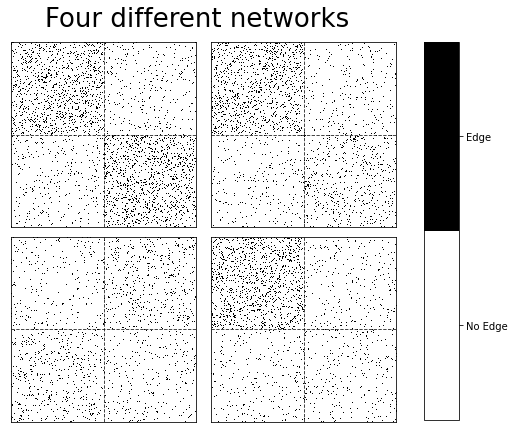

In [11]:
from graspologic.plot import binary_heatmap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


fig, axs = plt.subplots(2, 2, figsize=(7,7))
for ax, graph in zip(axs.flat, [A1, A2, A3, A4]):
    hmap = binary_heatmap(graph, ax=ax, cbar=False)
    for spine in ax.spines.values():
        spine.set_visible(True)
    hmap.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    hmap.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    
plt.suptitle("Four different networks", fontsize=26, y=.95)
fig.subplots_adjust(hspace=.05, wspace=.05)

cmap = ListedColormap(["white", "black"])
cbar_ax = fig.add_axes([.95, 0.13, 0.07, 0.75])
cbar = fig.colorbar(hmap.imshow(A1, cmap=cmap), cax=cbar_ax)
cbar.set_ticks([0.25, 0.75])
cbar.set_ticklabels(["No Edge", "Edge"])

First, we're going to embed each network separately. Doing this lets us 

In [ ]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

networks = [A1, A2, A3, A4]
latents = []
for network in networks:
    ase = ASE(n_components=2)
    latent = ase.fit_transform(network)
    latents.append(latent)

In [ ]:
import seaborn as sns
import warnings; warnings.filterwarnings("ignore")

def plot_latents(latent_positions, *, title, labels, ax=None, legend=False):
    if ax is None:
        ax = plt.gca()
    plot = sns.scatterplot(latent_positions[:, 0], latent_positions[:, 1], hue=labels, 
                           s=10, ax=ax, palette="Set1")
    plot.set_title(title, wrap=True);
#     ax.axes.xaxis.set_visible(False)
#     ax.axes.yaxis.set_visible(False)
    if legend:
        ax.legend(loc="upper right", title="Community")
    else:
        ax.get_legend().remove()
    
    return plot

fig, axs = plt.subplots(2, 2, figsize=(5,5), sharex=True, sharey=True)
for i, ax in enumerate(axs.flat):
    plot_latents(latents[i], title=None, labels=labels, ax=ax)
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
plt.suptitle("Embeddings of our four networks");

Multiple Adjacency Spectral Embedding (MASE) is an extension of Adjacency Spectral Embedding (see ASE tutorial) for an arbitrary number of graphs. Once graphs are embedded, the low-dimensional Euclidean representation can be used to visualize the latent positions of vertices, perform inference, etc.

The general idea of MASE is to take a bunch of graphs, embed them with Adjacency Spectral Embedding, and then combine those embeddings into a single matrix and re-embed the combined matrix. 

```{figure} ../../Images/mase1.jpeg
---
height: 400px
name: mase-fig
---
The MASE algorithm
```

We sample two 2-block SBMs (undirected, no self-loops) with 50 vertices, each block containing 25 vertices (𝑛=[25,25]), and with the following block connectivity matrices:

𝐵1=[0.30.10.10.7], 𝐵2=[0.30.10.10.3]

The only difference between the two is the within-block probability for the second block. We sample 𝐺1∼SBM(𝑛,𝐵1) and 𝐺2∼SBM(𝑛,𝐵2).

In [ ]:
from graspologic.embed import MultipleASE as MASE

mase = MASE(n_components=2)
latents = mase.fit_transform(networks)

plot_latents(latents, title="MASE embedding", labels=labels)